# Task 4

Estimate the expected lifetime, after surgery, of a woman who survives the first 12 months following surgery, but whose breast cancer has also reappeared within the first 12 months, either locally or distant.

_Hint:_ Use rejection sampling. Simulate a number of women, and discard all simulations that do not meet the requirements. Do this until you have reached 1000 acceptable simulations.

**Solution:** Just to make it more clear the 5 states are the following:
1. Women with breast tumor removed, and are healty.
2. Cancer reappears locally (cancer reappears close to the removed tumor).
3. Cancer reappears distant from where it was operated (called distant metastatis).
4. Cancer both reappears locally and distant at same time.
5. Death.

So, we are asked to estimate the expected lifetime, after surgery, of women who survive first 12 months but have entered state 2 or state 3 within the first 12 months.

**Note:** We made the assumption that it was either state 2 or 3 that had to have appeared in the first 12 months, so we don't consider state 4 where the women has both a local and distant reappearance.

This is implemented in the code below:

In [ ]:
import numpy as np

# Our markov chain simulation, with given n: number of women and P: probability matrix (transition matrix)
def am_12_months(n, P):
    lifetime = []
    accepted_sims = 0
    while accepted_sims < n:
        state = []
        t = 0 # Time variable controlling the 12 months horizon, we start in first month
        acceptable = False # If the simulation is acceptable or not

        # Initial state
        current_state = 0 # state 1 --> index 0
        state.append(current_state) # first state which is always state 1

        while current_state != 4:  # Absorbing state (death state)
            t += 1
            # Making a jump based on p=P[current state], returning the state index (state nr. -1)
            next_state = np.random.choice([0, 1, 2, 3, 4], p=P[current_state])

            state.append(next_state) # Keeping records of which state the women is in
            current_state = next_state # Change of state to next state

            if (current_state == 1 or current_state == 2) and t <= 12:
                acceptable = True

            if current_state == 4 and acceptable and t > 12: # Death state, but has entered either state 2 or 3 in
                lifetime.append(state)                       # first 12 months and has survived more than 12 months
                accepted_sims += 1

    return lifetime

# Probability matrix P with probabilities:
P = np.array([
    [0.9915, 0.005, 0.0025, 0.0, 0.001],  # state 1 to all the other
    [0.0, 0.986, 0.005, 0.004, 0.005],   # state 2: local recurrence
    [0.0, 0.0, 0.992, 0.003, 0.005],   # state 3:  distant metastatis
    [0.0, 0.0, 0.0, 0.991, 0.009],   # state 4: both local recurrence and distant metastatis
    [0.0, 0.0, 0.0, 0.0, 1.0]    # state 5: death state, no return hence 1.0 probabilites in P_[4][4]
])

nr_women = 1_000
## Simulating ##
lifetime = am_12_months(nr_women, P)


In [ ]:
lifetimes_month = []
for i in range(len(lifetime)):
    lifetime_list = lifetime[i]
    lifetimes_month.append(len(lifetime_list))

lifetimes = np.array(lifetimes_month) # Calculating the lifetime of each women, in months
expected_lifetime = np.mean(lifetimes)

print(f"The expected lifetime is {expected_lifetime:.2f} in months or {expected_lifetime/12:.2f} in years.")

The expected lifetime is 173.84 in months or 14.49 in years.


# Task 5
What fraction of women die within the first 350 months? Answer this by simulating 200 women, and record the fraction. Do this 100 times. Use control variates to reduce the variance. How large a reduction in variance do you see, using control variates, as opposed to the crude Monte Carlo estimator?

_Hint:_ Use the mean lifetime after surgery of the 200 simulations as the control variate.

In [80]:
# Our markov chain simulation, with given n: number of women
# and P: probability matrix (transition matrix)
def absorbing_markov(n, P):
    lifetime = []
    for _ in range(n):
        state = []
        # Initial state
        current_state = 0 # state 1 --> index 0
        state.append(current_state) # first state which is always state 1
        k = 0
        while current_state != 4:  # Absorbing state (death state)
            # Making a jump based on p=P[current state], returning the state index (state nr. -1)
            next_state = np.random.choice([0, 1, 2, 3, 4], p=P[current_state])
            state.append(next_state) # Keeping records of which state the women is in
            current_state = next_state # Change of state to next state
            k += 1
            if current_state == 4:
                lifetime.append(state) # keeping records of each lifetime

    return lifetime

# Probability matrix P with probabilities:
P = np.array([
[0.9915, 0.005, 0.0025, 0.0, 0.001], # state 1 to all the other
[0.0, 0.986, 0.005, 0.004, 0.005], # state 2: local recurrence
[0.0, 0.0, 0.992, 0.003, 0.005], # state 3:  distant metastatis
[0.0, 0.0, 0.0, 0.991, 0.009], # state 4: both local recurrence and distant metastatis
[0.0, 0.0, 0.0, 0.0, 1.0] # state 5: death state, no return hence 1.0 probabilites in P_[4][4]
])

nr_women = 200
## Simulating ##
lifetime = absorbing_markov(nr_women, P)
lifetime_means = []
fractions = []
for i in range(nr_women):
    lifetime = absorbing_markov(nr_women, P)
    lifetimes = np.array([len(lifetime[i]) for i in range(len(lifetime))])

    lifetime_means.append(np.mean(lifetimes))

    # Calculating the fraction of women who die within the first 350 months
    fraction = np.mean(np.where(lifetimes <= 350, 1, 0))
    fractions.append(fraction)


In [81]:
fraction_mean = np.mean(fractions)
fraction_variance = np.var(fractions)

c = - np.cov(fractions, lifetime_means)[0, 1] / np.var(lifetime_means)
control_fraction_mean = fractions + c * (lifetime_means - np.mean(lifetime_means))
control_fraction_variance = np.var(control_fraction_mean)

print(f"Fraction estimate: {fraction_mean}")
print(f"Fraction variance: {fraction_variance}")
print(f"Control fraction variance: {control_fraction_variance}")
print(f"Difference in variance: {fraction_variance - control_fraction_variance}")

Fraction estimate: 0.7366750000000001
Fraction variance: 0.0009125693750000008
Control fraction variance: 0.00035673881016694243
Difference in variance: 0.0005558305648330584


# Task 6
For the report, consider the following questions: What assumptions underlie the discrete time Markov chain model? Are those assumptions realistic? How may we relax some of these assumptions, possibly at the cost of increased
model complexity?

**Solution:** The assumptions that are not realistic are
1. the probability of transitioning to the next state depends only on the current state,
2. the transition probabilities between states are constant over time.

These assumptions are not realistic since the current state does not necesserally depend on transitiong to another state as previous states could as well influence a transition. And the transition probabilites very likely change with time, as we get older some things are more likely to happen such as dying.

We could relax these assumptions by considering a chain where the next state depends on the last $k$ states $(k > 1)$ and have the probability matrix dynamical and have it evolve with time. This would of course increase the model complexity.

# Task 7

As before, we choose one time-unit equal to one month. Use the following transition-rate matrix:
$$
\mathbf{Q}=\left[\begin{array}{ccccc}
-0.0085 & 0.005 & 0.0025 & 0 & 0.001 \\
0 & -0.014 & 0.005 & 0.004 & 0.005 \\
0 & 0 & -0.008 & 0.003 & 0.005 \\
0 & 0 & 0 & -0.009 & 0.009 \\
0 & 0 & 0 & 0 & 0
\end{array}\right]
$$

Simulate 1000 women, all starting in state 1, until death. Summarize the lifetime distribution after surgery, for example in a histogram. Report the mean, along with a confidence interval, and the standard deviation, also with a confidence interval. In what proportion of women has the cancer reappeared distantly after 30.5 months?


In [92]:
import numpy as np

# Our markov chain simulation, with given n: number of women
# and Q: transition rate matrix
def continuouse_absorbing_markov(n, Q):
  P = np.zeros_like(Q)

  # Populate the probability matrix P
  for i in range(Q.shape[0] - 1):
      P[i, i+1:] = -Q[i, i+1:] / Q[i, i]

  lifetime = []
  cancer_reappeared_count = 0
  for _ in range(n):
      sojourn_time = 0
      cancer_reappeared = False

      # Initial state
      current_state = 0 # state 1 --> index 0

      while current_state != 4:  # Absorbing state (death state)

        sojourn_time += np.random.exponential(scale=-1/Q[current_state, current_state])

        if (current_state == 2 or current_state == 3) and sojourn_time >= 30.5:
          cancer_reappeared = True

        # Making a jump based on p=P[current state], returning the state index (state nr. -1)
        next_state = np.random.choice([0, 1, 2, 3, 4], p=P[current_state])
        current_state = next_state # Change of state to next state

        if current_state == 4:
          lifetime.append(sojourn_time)

          if cancer_reappeared:
            cancer_reappeared_count += 1


  return lifetime, cancer_reappeared_count

Q = np.array([[-0.0085, 0.005, 0.0025, 0, 0.001],
              [0, -0.014, 0.005, 0.004, 0.005],
              [0, 0, -0.008, 0.003, 0.005],
              [0, 0, 0, -0.009, 0.009],
              [0, 0, 0, 0, 0]])

nr_women = 1_000
## Simulating ##
lifetime, cancer_reappeared_count = continuouse_absorbing_markov(nr_women, Q)

Mean Lifetime after Surgery: 259.10 months
Standard Deviation: 187.32 months
95% Confidence Interval for Mean Lifetime: (247.49, 270.71) months
Proportion of Women with Cancer Reappearance after 30.5 months: 66.30%


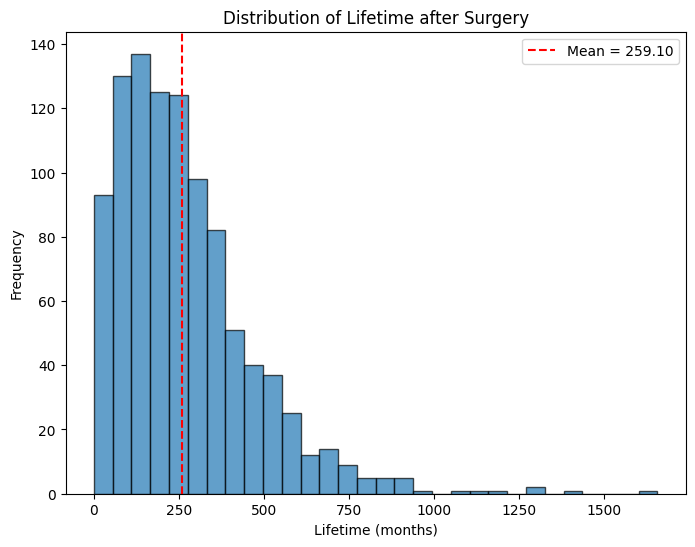

In [93]:
# Calculate statistics
mean_lifetime = np.mean(lifetimes)
std_deviation = np.std(lifetimes)
confidence_interval = stats.norm.interval(0.95, loc=mean_lifetime, scale=std_deviation/np.sqrt(nr_women))

# Print results
print(f"Mean Lifetime after Surgery: {mean_lifetime:.2f} months")
print(f"Standard Deviation: {std_deviation:.2f} months")
print(f"95% Confidence Interval for Mean Lifetime: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}) months")
print(f"Proportion of Women with Cancer Reappearance after 30.5 months: {cancer_reappeared_count / nr_women:.2%}")

# Plot histogram of lifetimes
plt.figure(figsize=(8, 6))
plt.hist(lifetime, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(mean_lifetime, color='red', linestyle='dashed', linewidth=1.5, label=f'Mean = {mean_lifetime:.2f}')
plt.title('Distribution of Lifetime after Surgery')
plt.xlabel('Lifetime (months)')
plt.ylabel('Frequency')
plt.legend()
plt.show()
